# Table of Contents
* [Getting Ready](#chapter1)
    * [Requiered Extensions](#section_1_1)
    * [Needed Files](#section_1_2)
    * [LUT and Stats Files](#section_1_3)
* [Segmentation](#chapter2)
    * [Accesing the Volume](#section_2_1)
    * [Segmentation](#section_2_2)
        * [Color Mapping](#section_2_2_1)
        * [Individual Segmentations](#section_2_2_2)


## Getting Ready <a class="anchor" id="chapter1"></a>

Befor preparing to extract each segment by the each color contained in the image. 
We must previously import the necesary extensions and prepare some files.

### Getting Ready: Requiered Extensions <a class="anchor" id="section_1_1"></a>

In [13]:
import os
import random
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting, image
from matplotlib.colors import ListedColormap

### Getting Ready: Needed Files <a class="anchor" id="section_1_2"></a>

First we must establish the path where our files are stored. 
In this case, the aparc+aseg volume path, the brain volume path and the Look Up Table pathare the most important.
Afterwards, we load the volumes using the nibabel library.

In [14]:
# Main path where all requiered files are encountered.
mainPath = os.path.join('/home/danvalcor/Documents/ANDI/Sample010')

# Specific path for the volumes.
asegPath = f'{mainPath}/mri/aparc+aseg.mgz'
brainPath = f'{mainPath}/mri/brain.mgz'

# We are also including the stats file to save the known stats.
asegStats = f"{mainPath}/stats/aseg.stats"

# Path to load the LUT table
LUTfile = os.path.join(os.environ['FREESURFER_HOME'],'luts/FreeSurferColorLUT.txt')

# Load the MRI libraries using the nibabel library
brain = nib.load(brainPath)   # Volume containing the MRI of the brain.
aseg = nib.load(asegPath)     # Volume containing the segmentations of the brains MRI

 ### Getting Ready: LUT and Stats Files <a class="anchor" id="section_1_3"></a>

After establishing the required paths, we must obtain from freesurfer the LUT (Look Up Table) that contains the name and rgb values corresponding to each segmentation id. 
For this FreeSurfer *must* be installed. And the corresponding enviroment variables declared.

In [15]:
# Create a data Frame to contain all relevant information of the LUT
df = pd.DataFrame(columns=["Id", "Segmentation","Color Array"])

# Declares the path where the LUT file is stored inside FreeSurfers Directory. 
lut_data = []

# Opens and reads the file
with open(LUTfile, "r") as file:
    content = file.readlines()

# Reads each line of the file
for line in content:
    # Skip empty lines
    if len(line) > 1:
        # Strip, split and join each line by the tab ('\t') separator, to assign each value easier
        sLine = line.strip().split("\t")
        sLine = " ".join(sLine).split()
        # Checks and skipps anotations in the file
        if '#' not in sLine[0]:
            # Separates and assigns the contained values to the dictionary
            labelId = int(sLine[0])                     # Converts the numbers back into integers.
            labelName = sLine[1]                        # Assigns the structure labels.
            rgbColors = [int(p) for p in sLine[-4:-1]]  # Converts each rgb value back into integers.
            lut_data.append({"Id": labelId, "StructName": labelName, "Color Array": rgbColors})

# Create DataFrame from the list of dictionaries
df = pd.DataFrame(lut_data)# Prints the dictionary to verify


In [16]:
# Shows the stored information on the Data Frame.
print(df)

         Id                   StructName      Color Array
0         0                      Unknown        [0, 0, 0]
1         1       Left-Cerebral-Exterior   [70, 130, 180]
2         2   Left-Cerebral-White-Matter  [245, 245, 245]
3         3         Left-Cerebral-Cortex    [205, 62, 78]
4         4       Left-Lateral-Ventricle   [120, 18, 134]
...     ...                          ...              ...
1470  14171           wm_rh_S_suborbital     [21, 20, 60]
1471  14172          wm_rh_S_subparietal    [101, 60, 60]
1472  14173         wm_rh_S_temporal_inf   [21, 180, 180]
1473  14174         wm_rh_S_temporal_sup   [223, 220, 60]
1474  14175  wm_rh_S_temporal_transverse    [221, 60, 60]

[1475 rows x 3 columns]


From this we have a Data Frame that we can use to portray each segment contained in our files. In this case it's important to notice that the number corresponding to our last label (or biggest) is actually bigger than actual number of labels contained in the file. -_*This indicates that there is a non linear increment happening to the labels id.*_- Thats why its important to store the corresponding ID.

For the Stats File, we are going to read everything contained in it. Using the declared headers in it to order and the data in a homogeneous way.

In [17]:
# Opens and reads the file
with open(asegStats, "r") as file:
    content = file.readlines()

statsData = []
headers = []
# Reads each line of the file
for line in content:
    if "ColHeader" in line:
        # Agrega los encabezados a la lista de encabezados
        headers.append(line.split()[-1])
        headers = " ".join(headers)
        headers = headers.split()
    elif line.split()[0] != '#':
        statsData.append(line.split())

# Creates a Data Frame that contains the Stats information, using the corresponding headers.
df2 = pd.DataFrame(statsData, columns=headers[:-1])

# Shows the Data Frame
print(df2)

   Index SegId NVoxels Volume_mm3                     StructName  normMean  \
0      1     4   22632    22916.7         Left-Lateral-Ventricle   22.3582   
1      2     5    1001     1037.6              Left-Inf-Lat-Vent   40.3996   
2      3     7   14400    15284.4   Left-Cerebellum-White-Matter   84.5986   
3      4     8   56493    56362.0         Left-Cerebellum-Cortex   60.7487   
4      5    10    7691     7477.0                  Left-Thalamus   93.1047   
5      6    11    3043     3038.2                   Left-Caudate   79.6329   
6      7    12    4344     4360.2                   Left-Putamen   89.5014   
7      8    13    2258     2192.2                  Left-Pallidum  103.5793   
8      9    14    2023     2036.9                  3rd-Ventricle   26.8942   
9     10    15    1353     1502.2                  4th-Ventricle   28.6474   
10    11    16   19984    20039.9                     Brain-Stem   83.5514   
11    12    17    3646     3495.5               Left-Hippocampus

We must start cleaning the stored data. Not every segmentation will contain the same structures. So we must retain the segmentations of which we have data and those that are actually present on our ASEG volume.

In [18]:
# Merges and mantainsonly the information of present segmentations. These way we have present the RGB values.
df2 = pd.merge(df, df2, left_on="StructName", right_on="StructName", how="inner")


# Eliminates the Index and SegId since these both are duplicated
df2.drop(columns=["Index", "SegId"], inplace=True)

# Mostrar el DataFrame resultante que contiene las coincidencias
print(df2)

     Id                     StructName      Color Array NVoxels Volume_mm3  \
0     4         Left-Lateral-Ventricle   [120, 18, 134]   22632    22916.7   
1     5              Left-Inf-Lat-Vent   [196, 58, 250]    1001     1037.6   
2     7   Left-Cerebellum-White-Matter  [220, 248, 164]   14400    15284.4   
3     8         Left-Cerebellum-Cortex   [230, 148, 34]   56493    56362.0   
4    10                  Left-Thalamus     [0, 118, 14]    7691     7477.0   
5    11                   Left-Caudate  [122, 186, 220]    3043     3038.2   
6    12                   Left-Putamen   [236, 13, 176]    4344     4360.2   
7    13                  Left-Pallidum    [12, 48, 255]    2258     2192.2   
8    14                  3rd-Ventricle  [204, 182, 142]    2023     2036.9   
9    15                  4th-Ventricle   [42, 204, 164]    1353     1502.2   
10   16                     Brain-Stem  [119, 159, 176]   19984    20039.9   
11   17               Left-Hippocampus   [220, 216, 20]    3646 

## Segmentation <a class="anchor" id="chapter2"></a>


### Accesing the Volume <a class="anchor" id="section_2_1"></a>


In [19]:
# We obtain and save the data present in our segmentation volume.
img_data = aseg.get_fdata()
print(aseg.shape)

(256, 256, 256)


We can use plotting from nilearn to view in different ways our volumes. In this first example, using a roi view with the brain volume as the background image.

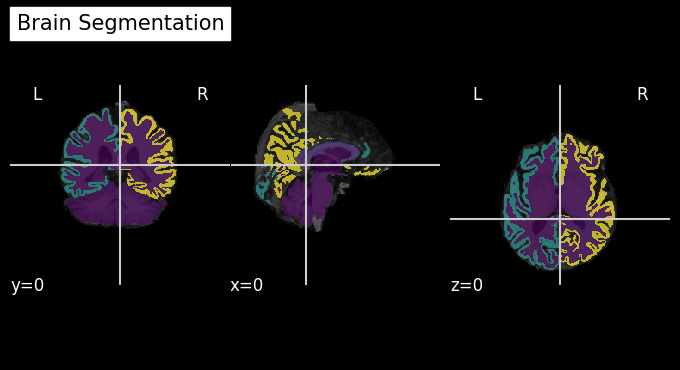

In [20]:
plotting.plot_roi(aseg, bg_img=brain, title='Brain Segmentation',cut_coords=(0,0,0), cmap="viridis")

# Show the image
plt.show()

#### Color Mapping <a class="anchor" id="section_2_2_1"></a>


We are going to use de Data Frame containing the information of the LUT, to generate a Color Map to properly view the segmentations present in the volume.

In [21]:
colors = dict() # Creates an empty dictonary to store every Id to its RGB color array.
for _, row in df.iterrows():
    colorId, color = row[['Id', 'Color Array']]
    colors[colorId] = [color[0]/255.0, color[1]/255.0, color[2]/255.0, .9]
cmap = ListedColormap(list(colors.values()))

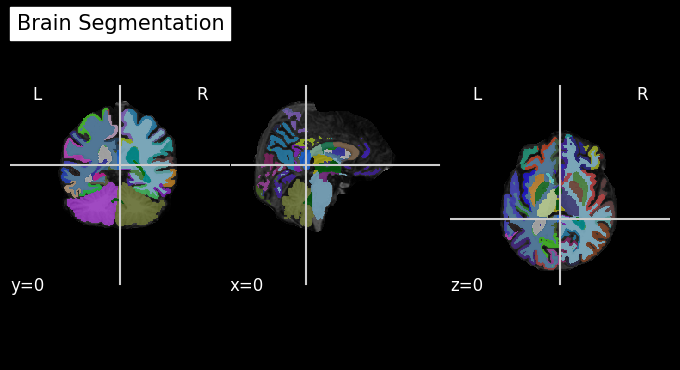

In [26]:
plotting.plot_roi(aseg, bg_img=brain, title='Brain Segmentation',cut_coords=(0,0,0), cmap=cmap)

# Show the image
plt.show()

In [22]:
# Creates a temporary array to store the number of voxels present in every segmet.
calculated = []

# iterates each row present in the Data Frame
for i, row in df.iterrows():
    # Assigns the id, structure Name, and corresponding color
    colorId, name, color = row[['Id','StructName','Color Array']]
    # Create a boolean mask for values in img_data matching the Id value
    mask = (img_data == colorId)
    # Calculate the number of voxels
    num_voxels = np.count_nonzero(mask)
    calculated.append(num_voxels)

# Add the calculated list as a new column named "calculated" to the DataFrame
df['NVoxels'] = calculated
# Remove rows where 'NVoxels' is 0, and resets the index of the dataFrame
df = df[df['NVoxels'] != 0].reset_index(drop=True)

# Show the resulting DataFrame
print("Present Segments: ",len(df))
print(df)

Present Segments:  111
       Id                    StructName      Color Array   NVoxels
0       0                       Unknown        [0, 0, 0]  15611097
1       2    Left-Cerebral-White-Matter  [245, 245, 245]    237966
2       4        Left-Lateral-Ventricle   [120, 18, 134]     22632
3       5             Left-Inf-Lat-Vent   [196, 58, 250]      1001
4       7  Left-Cerebellum-White-Matter  [220, 248, 164]     14400
..    ...                           ...              ...       ...
106  2031          ctx-rh-supramarginal    [80, 160, 20]      8190
107  2032            ctx-rh-frontalpole    [100, 0, 100]       921
108  2033           ctx-rh-temporalpole     [70, 70, 70]      2314
109  2034     ctx-rh-transversetemporal  [150, 150, 200]       665
110  2035                 ctx-rh-insula   [255, 192, 32]      6983

[111 rows x 4 columns]


/tmp/ipykernel_4497/441994646.py:13: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  masked_img = image.new_img_like(aseg, masked_img_data)


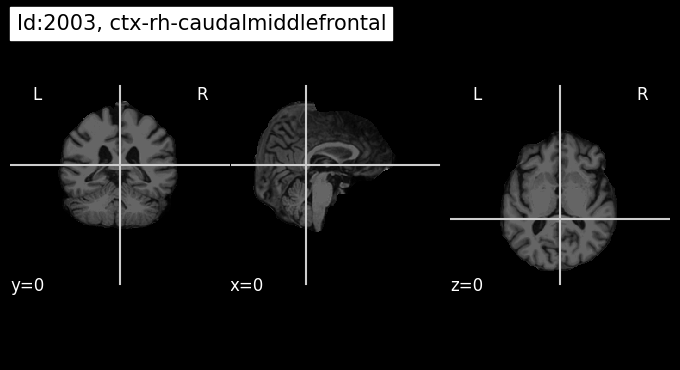

79


In [23]:
img_data = aseg.get_fdata()
# Generate a random value within the range of the DataFrame's size
randValue = random.randint(0, df['Id'].size)

# Extract ID, StructName, and Color Array based on the randomly selected row
colorId, name, color = df[['Id', 'StructName', 'Color Array']].loc[randValue].values

# Create a boolean mask for values in img_data matching the colorId
mask = (img_data == colorId)

# Apply the logical mask
masked_img_data = np.where(mask, colorId, 0)
masked_img = image.new_img_like(aseg, masked_img_data)

# Show the image with its corresponding color
plotting.plot_roi(masked_img, black_bg= True, bg_img=brain, cut_coords=(0, 0, 0), cmap=ListedColormap([color]), title=f'Id:{colorId}, {name}')
plt.show()

# Print the randomly selected row index for reference
print(randValue)

This code is to show every segmentation present.

In [24]:
"""
for i, row in df.iterrows():
    colorId, name, color = row[['Id','StructName','Color Array']]
    # Crear una máscara booleana para los valores de img_data que coinciden con el valor de Id
    mascara = (img_data == colorId)
    
    # Aplica la máscara lógica
    masked_img_data = np.where(mascara, colorId, 0)
    masked_img = image.new_img_like(aseg, masked_img_data)
    # Mostrar la imagen
    plotting.plot_roi(masked_img, black_bg=True, bg_img=None, cut_coords=(0, 0, 0), cmap=ListedColormap([color]), title=f'Id:{colorId}, Color {name}')
    plt.show()
"""

"\nfor i, row in df.iterrows():\n    colorId, name, color = row[['Id','StructName','Color Array']]\n    # Crear una máscara booleana para los valores de img_data que coinciden con el valor de Id\n    mascara = (img_data == colorId)\n    \n    # Aplica la máscara lógica\n    masked_img_data = np.where(mascara, colorId, 0)\n    masked_img = image.new_img_like(aseg, masked_img_data)\n    # Mostrar la imagen\n    plotting.plot_roi(masked_img, black_bg=True, bg_img=None, cut_coords=(0, 0, 0), cmap=ListedColormap([color]), title=f'Id:{colorId}, Color {name}')\n    plt.show()\n"

## 3D visualizing
In this section we are going to breifly explore the visualization of the volumes. For a segment and the complete brain.
In this case we will use vtk, allthough the mayavi pipeline its easier to implement. Also, while matplot can be used, some volumes and meshes may be to much for the renderer and therefore be a bad experience visualizing.

In [25]:
# VTK
import vtk
from vtkmodules.util.numpy_support import numpy_to_vtk

imgData = aseg.get_fdata()  
    
# Convert the numpy array to a VTK image data object
vtk_data = vtk.vtkImageData()
vtk_data.SetDimensions(imgData.shape)
vtk_data.SetSpacing(aseg.header.get_zooms())
    
volume_mapper = vtk.vtkFixedPointVolumeRayCastMapper()
volume_mapper.SetInputData(vtk_data)
    
flat_data = imgData.ravel(order='F')  # Flatten the numpy array
vtk_flat_data = numpy_to_vtk(num_array=flat_data, deep=True, array_type=vtk.VTK_FLOAT)
vtk_data.GetPointData().SetScalars(vtk_flat_data)

# Create transfer mapping scalar value to opacity
opacityTransferFunction = vtk.vtkPiecewiseFunction()
opacityTransferFunction.AddPoint(0, 0.0)
opacityTransferFunction.AddPoint(255, 0.2)


# Create transfer mapping scalar value to color
colorTransferFunction = vtk.vtkColorTransferFunction()
        
# Get the unique labels to map the volumes.
for i in np.unique(imgData):
    rgb = colors[i]
    colorTransferFunction.AddRGBPoint(i, rgb[0], rgb[1], rgb[2])
        
# Create a volume rendering
volumeProperty = vtk.vtkVolumeProperty()
volumeProperty.SetColor(colorTransferFunction)
volumeProperty.SetScalarOpacity(opacityTransferFunction)
        
# The mapper / ray cast function know how to render the data
volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
volumeMapper.SetInputData(vtk_data)
        
# The volume holds the mapper and the property and can be used to position/orient the volume
volume = vtk.vtkVolume()
volume.SetMapper(volumeMapper)
volume.SetProperty(volumeProperty)
        
# Crear el renderizador, la ventana de renderizado y el interactor
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)

render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)

# Añadir el volumen al renderizador
renderer.AddVolume(volume)
renderer.SetBackground(0, 0, 0)  # Fondo negro

# Iniciar el interactor
render_window.Render()
render_window_interactor.Start()
